# Neural Network

## Load Data

In [1]:
from timeit import default_timer as timer
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np
import tensorflow as tf

In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 7:
Image - Min Value: 17 Max Value: 221
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


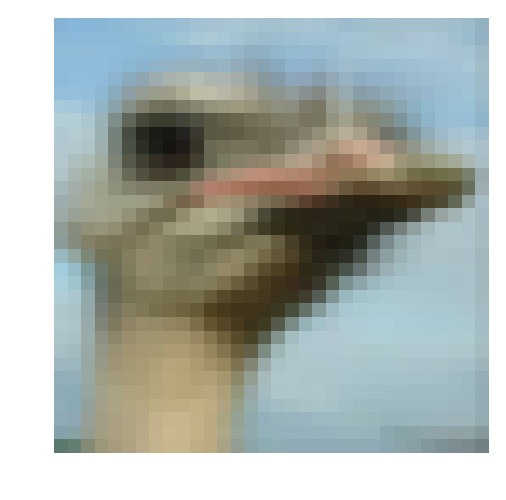

In [3]:
# Explore the dataset
batch_id = 4
sample_id = 7
batch_size = 5
image_sizes = 32
image_channels = 3
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocess Data

In [4]:
def normalize(x):
    x_min = np.min(x)
    return (x - x_min)/(np.max(x) - x_min)

def one_hot_encode(x):
    encoder = tf.one_hot(x, 10)
    encodings = None
    with tf.Session() as sess:
        encodings = sess.run(encoder)
    return encodings

In [35]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Check Point

In [4]:
import pickle
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build Netwrok

In [5]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

In [6]:
def leaky_relu(x, alpha):
    return tf.maximum(x * alpha, x)

def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    tmp1 = scale * tf.nn.elu(x)
    tmp2 = scale * alpha * (tf.nn.elu(-1*tf.nn.relu(-1*x)))
    return tmp1 + tmp2

In [7]:
class Network(object):
    
    def __init__(self, l1_kernel=3, l1_depth=128, l2_kernel=3, l2_depth=64):
        self.l1_kernel = l1_kernel
        self.l1_depth = l1_depth
        self.l2_kernel = l2_kernel
        self.l2_depth = l2_depth
        # Inputs
        self.x, self.y, self.keep_prob, self.learning_rate = self.init_placeholders((32, 32, 3), 10)
        # Model
        logits = self.build()
        # Name logits Tensor, so that is can be loaded from disk after training
        logits = tf.identity(logits, name='logits')
        # Loss and Optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        # Accuracy
        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    def init_placeholders(self, image_shape, n_classes):
        height, width, depth = image_shape
        x = tf.placeholder(tf.float32, [None, height, width, depth], name='x')
        y = tf.placeholder(tf.float32, [None, n_classes], name='y')
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')
        return x, y, keep_prob, learning_rate

    def build(self):
        l1 = tf.layers.conv2d(self.x, self.l1_depth, kernel_size=self.l1_kernel, strides=2, padding='same')
        l1_act = selu(l1)
        l1_drop = tf.nn.dropout(l1_act, keep_prob=self.keep_prob)

        l2 = tf.layers.conv2d(l1_drop, self.l2_depth, kernel_size=self.l2_kernel, strides=2, padding='same')
        l2_act = selu(l2)
        l2_drop = tf.nn.dropout(l2_act, keep_prob=self.keep_prob)

        l3 = tf.layers.conv2d(l2_drop, 64, 3, padding='same')
        l3_act = selu(l3)

        lfc = tf.reshape(l3_act, (-1, 8*8*64))

        logits = tf.layers.dense(lfc, 10)
        return logits

In [8]:
def print_stats(session, net, total_epochs, epoch, batch_i, feature_batch, label_batch):
    train_loss = session.run(net.cost, feed_dict={net.x:feature_batch, net.y:label_batch, net.keep_prob:1.})
    valid_loss = session.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels, net.keep_prob:1.})
    train_accuracy = session.run(net.accuracy, feed_dict={net.x:feature_batch, net.y:label_batch, net.keep_prob:1.})
    valid_accuracy = session.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels, net.keep_prob:1.})
    print('Epoch {:>2}/{:>2}, CIFAR-10 Batch {} | Train Acc: {:1.2} Loss: {:1.3} | Valid Acc: {:1.2} Loss: {:1.3}'.format(
        epoch, total_epochs, batch_i, train_accuracy, train_loss, valid_accuracy, valid_loss), end='\r')

# Genetic Algorithm

In [9]:
import numpy as np
from operator import attrgetter
import string
import random

In [10]:
class Individual(object):
    
    def __init__(self, gene=None, mutation_rate=0.01):
        self.mutation_rate = mutation_rate
        self.gene = gene
        self.score = -1
        self.evaluation_time = 0.0
        
        # define genotypes
        self.genotype_batch = [16, 32, 64, 92, 128, 256]
        self.genotype_learning_rate = [.01, .02, .03, .05, .001, .002, .003, .005, .0001, .0002, .0003, .0005]
        self.genotype_keep_probab = [.4, .5, .6, .7, .8, .9, .95, .98]
        self.genotype_conv2d_l1_kernel = [3, 5, 7]
        self.genotype_conv2d_l1_depth = [32, 64, 92, 128, 256, 512]
        self.genotype_conv2d_l2_kernel = [3, 5, 7]
        self.genotype_conv2d_l2_depth = [32, 64, 92, 128, 256, 512]
        
        # define penalties
        self.loss_mult = .1
        self.accuracy_mult = 3
        self.accuracy_delta_mult = 5
        self.penalty = 99999
        
        self.network_epochs = 5
        self.max_time = 50
        
        if gene == None:
            self.gene_length = 0
        else:
            self.gene_length = len(self.gene)
        
    def generate(self):
        self.gene = []
        self.gene.append(random.choice(self.genotype_batch))
        self.gene.append(random.choice(self.genotype_learning_rate))
        self.gene.append(random.choice(self.genotype_keep_probab))
        self.gene.append(random.choice(self.genotype_conv2d_l1_kernel))
        self.gene.append(random.choice(self.genotype_conv2d_l1_depth))
        self.gene.append(random.choice(self.genotype_conv2d_l2_kernel))
        self.gene.append(random.choice(self.genotype_conv2d_l2_depth))
        self.gene_length = len(self.gene)
        
    def fitness(self):
        self.score = 0
        net = Network(l1_kernel=self.gene[3], 
                      l1_depth=self.gene[4],
                      l2_kernel=self.gene[5], 
                      l2_depth=self.gene[6])
        try:
            batch_size = self.gene[0]
            learning_rate = self.gene[1]
            keep_probability = self.gene[2]
            start = timer()
            with tf.Session() as sess:
                # Initializing the variables
                sess.run(tf.global_variables_initializer())
                # Training cycle
                for epoch in range(self.network_epochs):
                    # Loop over all batches
                    n_batches = 1
                    for batch_i in range(1, n_batches + 1):
                        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                            fd = {net.x:batch_features, 
                                  net.y:batch_labels, 
                                  net.keep_prob:keep_probability, 
                                  net.learning_rate:learning_rate}
                            sess.run(net.optimizer, feed_dict=fd)
                        print_stats(sess, net, self.network_epochs, epoch + 1, batch_i, batch_features, batch_labels)
                    if (timer() - start) > self.max_time:
                        raise TimeoutError('Dropped Individual')
                
                end = timer()
                self.evaluation_time = end - start
                
                train_loss = sess.run(net.cost, feed_dict={net.x:batch_features, net.y:batch_labels, net.keep_prob:1.})
                valid_loss = sess.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels, net.keep_prob:1.})
                train_accuracy = sess.run(net.accuracy, feed_dict={net.x:batch_features, net.y:batch_labels, net.keep_prob:1.})
                valid_accuracy = sess.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels, net.keep_prob:1.})

                self.score = (self.evaluation_time / 10) \
                    + train_loss*self.loss_mult \
                    + valid_loss*self.loss_mult \
                    + (1-train_accuracy)*self.accuracy_mult \
                    + (1-valid_accuracy)*self.accuracy_mult \
                    + np.abs(train_accuracy-valid_accuracy)*self.accuracy_delta_mult
        except:
            self.score = self.penalty
            return

    def cross_over(self, parent):
        cross_over_point = len(self.gene) // 2
        child = []
        for i in range(0, cross_over_point):
            child.append(self.gene[i])
        for i in range(cross_over_point, self.gene_length):
            child.append(parent.gene[i])
        return Individual(gene=child, mutation_rate=self.mutation_rate)
        
    def mutate(self):
        for i in range(self.gene_length):
            prob = np.random.random_sample()
            if prob <= self.mutation_rate:
                continue
            if i == 0:
                # batch
                val = np.random.randint(10, 101)
                self.gene[0] += val
            elif i == 1:
                # learning rate
                val = np.random.random()
                self.gene[1] = val
            elif i == 2:
                # keep probability
                val = np.random.random()
                self.gene[2] = val
            elif i == 3:
                # conv2d l1 kernel
                val = np.random.randint(1, 3)
                self.gene[3] += val
            elif i == 4:
                # conv2d l1 depth
                val = np.random.randint(2, 17)
                self.gene[4] += val
            elif i == 5:
                # conv2d l2 kernel
                val = np.random.randint(1, 3)
                self.gene[5] += val
            elif i == 6:
                # conv2d l2 depth
                val = np.random.randint(2, 17)
                self.gene[6] += val
            else:
                raise NotImplementedError('Unknown genotype')


In [11]:
class Population(object):
    
    def __init__(self,
                 initial_population=200, 
                 max_generations=1000,
                 mutation_rate=0.01, 
                 elitism=True,
                 tournament_size=4,
                 solution_threshold=1.0):
        self.initial_population = initial_population
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism = elitism
        self.tournament_size = tournament_size
        self.solution_threshold = solution_threshold
        self.time_elapsed = 0.0
        self.global_best_individual = None
        self.global_best_solution = 88888
        self.current_best_individual = None
        self.current_best_solution = 88888
        self.generation = 0
        self.population = []
        
    def _evaluate_fitnesses_(self):
        for p in self.population:
            if p.score < 0:
                p.fitness()
                self.time_elapsed += p.evaluation_time
        self.current_best_individual = self.evaluate_current_best_individual()
        self.current_best_solution = self.current_best_individual.score
        if self.global_best_individual == None or self.global_best_solution > self.current_best_solution:
            self.global_best_individual = self.current_best_individual
            self.global_best_solution = self.current_best_solution

    def _perform_tournament_selection_(self):
        tournament = Population()
        for _ in range(self.tournament_size):
            i = random.choice(self.population)
            tournament.add_individual(i)
        return tournament.evaluate_current_best_individual()
    
    def generate(self):
        assert self.initial_population % 2 == 0
        self.population = [Individual(mutation_rate=self.mutation_rate) for _ in range(self.initial_population)]
        for p in self.population:
            p.generate()
    
    def evolve_generation(self):
        children_genes = []
        self._evaluate_fitnesses_()  
        
        if self.elitism:
            children_genes.append(self.current_best_individual)
            
        for _ in range(self.initial_population):
            # perform selection
            male = self._perform_tournament_selection_()
            female = self._perform_tournament_selection_()
            # perform cross-over
            new_individual = male.cross_over(female)
            # perform mutation
            new_individual.mutate()
            children_genes.append(new_individual)
            
        self.population = children_genes
        self.generation += 1
            
    def evaluate_current_best_individual(self):
        return min(self.population, key=attrgetter('score'))
    
    def found_solution(self):
        return self.global_best_solution < self.solution_threshold
    
    def add_individual(self, individual):
        self.population.append(individual)
    
    def print_score(self):
        print('Generation: {}/{}, Time {:2.2}s, Solution score: {}, Individual: {}'.format(
            self.generation, 
            self.max_generations,
            self.global_best_individual.evaluation_time,
            self.global_best_solution,
            self.global_best_individual.gene))    

In [12]:
# hypter-parameters
max_generations = 100
population_size = 100
mutation_rate = 0.05

In [13]:
def execute(max_generations, population_size, mutation_rate, display_interval=1):
    population = Population(population_size, max_generations)
    population.generate()
    while not population.found_solution() and population.generation < max_generations:
        population.evolve_generation()
        if population.generation % display_interval == 0:
            population.print_score()
    best_individual = population.global_best_individual
    print('\nGenerations: {}, Final score: {}, Final result: {}'.format(population.generation, best_individual.score, best_individual.gene))

In [ ]:
execute(max_generations, population_size, mutation_rate)

Generation: 1/100, Time 8.9s, Solution score: 4.49126531463059, Individual: [92, 0.002, 0.8, 3, 64, 3, 32]


## Train Network

In [10]:
epochs = 10
batch_size = 128
learning_rate = 0.0003
keep_probability = 1.
l1_kernel = 3
l1_depth = 128
l2_kernel = 3
l2_depth = 92

In [11]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    net = Network(l1_kernel=l1_kernel, 
                  l1_depth=l1_depth, 
                  l2_kernel=l2_kernel, 
                  l2_depth=l2_depth)
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                fd = {net.x:batch_features, net.y:batch_labels, net.keep_prob:keep_probability, net.learning_rate:learning_rate}
                sess.run(net.optimizer, feed_dict=fd)
            print_stats(sess, net, epochs, epoch + 1, batch_i, batch_features, batch_labels)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...


## Test Model

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.624307753164557



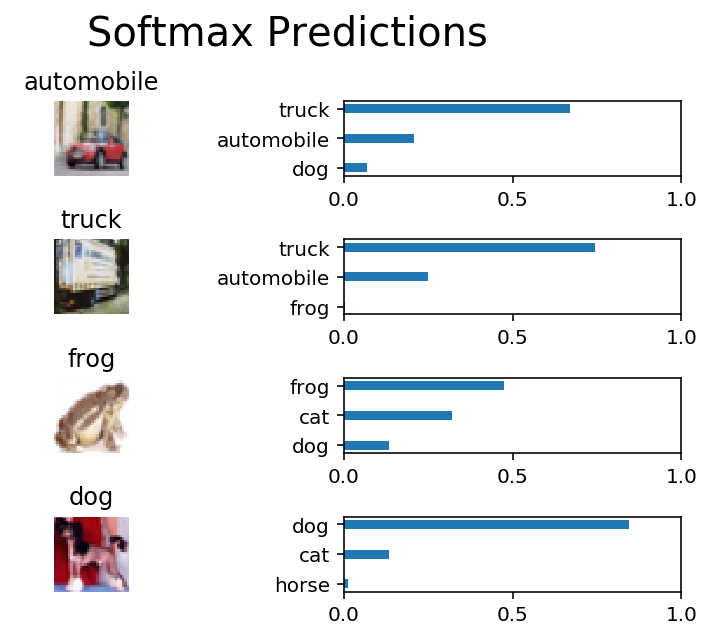

In [20]:
# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()